# Gaps on structure functions: demo of pipeline

- Inspired by existing code
- Test on one PSP to start, then two PSP and one Wind for training and testing
- Check against target dataframes as you go

4 x 2 intervals (1 input file) = 2-3min

### 0. Import dependencies

In [1]:
import pickle
import pandas as pd
import numpy as np
import ts_dashboard_utils as ts
import src.utils as utils  # copied directly from Reynolds project, normalize() added
import src.params as params
import src.sf_funcs as sf
import sys
import src.data_import_funcs as dif
import json
import glob
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.5)
#plt.rcParams.update({"font.size": 16})
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

In [2]:
# For current Wind importing

sys_arg_dict = {
    # arg1
    "mag_path": params.mag_path,
    "proton_path": params.proton_path,
    "electron_path": params.electron_path,
    # arg2
    "mag_vars": [params.timestamp, params.Bwind, params.Bwind_vec],
    "proton_vars": [params.timestamp, params.np, params.Tp],
    "electron_vars": [params.timestamp, params.ne, params.Te],
    # arg3
    "mag_thresh": params.mag_thresh,
    "proton_thresh": params.proton_thresh,
    "electron_thresh": params.electron_thresh,
    # arg4
    "dt_hr": params.dt_hr,
    "int_size": params.int_size,
    # arg5
    "dt_lr": params.dt_lr,
}

### 1. Download files

Run in terminal

In [3]:
# For selecting a range of dates

# wget --no-clobber --directory-prefix=data/raw/psp  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/psp_fld_l2_mag_rtn_20181102{00..12}_v02.cdf
# wget --no-clobber --directory-prefix=data/raw/wind/ https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/2016/wi_h2_mfi_201601{01..07}_v05.cdf

# For entire folders

# wget --no-clobber --directory-prefix=data/raw/psp --recursive -np -nv -nH --cut-dirs=7 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2018/
# wget --no-clobber --directory-prefix=data/raw/wind --recursive -np -nv -nH --cut-dirs=2 --accept cdf  https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h2/

### 2. Read in data and split into standardised intervals

#### PSP data

In [4]:
raw_file_list = sorted(glob.iglob("data/raw/psp/" + "/*.cdf"))
print(raw_file_list)

['data/raw/psp\\psp_fld_l2_mag_rtn_2018110200_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110206_v02.cdf', 'data/raw/psp\\psp_fld_l2_mag_rtn_2018110212_v02.cdf']


Remember, we are no longer reading in a bunch of files at once. Now, we are reading in one at a time.

In [5]:
psp_data = dif.read_cdfs(
    [raw_file_list[0]],  # LIMIT HERE!
    {"epoch_mag_RTN": (0), "psp_fld_l2_mag_RTN": (0, 3), "label_RTN": (0, 3)},
)
psp_data_ready = dif.extract_components(
    psp_data,
    var_name="psp_fld_l2_mag_RTN",
    label_name="label_RTN",
    time_var="epoch_mag_RTN",
    dim=3,
)
psp_df = pd.DataFrame(psp_data_ready)
psp_df["Time"] = pd.to_datetime("2000-01-01 12:00") + pd.to_timedelta(
    psp_df["epoch_mag_RTN"], unit="ns"
)
psp_df = psp_df.drop(columns="epoch_mag_RTN").set_index("Time")

df_raw = psp_df["B_R"]

print(df_raw.info())
print(df_raw.head())

reading file  data/raw/psp\psp_fld_l2_mag_rtn_2018110200_v02.cdf
Done reading data
<class 'pandas.core.series.Series'>
DatetimeIndex: 1582027 entries, 2018-11-02 00:01:09.195182976 to 2018-11-02 06:01:09.171900544
Series name: B_R
Non-Null Count    Dtype  
--------------    -----  
1582027 non-null  float64
dtypes: float64(1)
memory usage: 24.1 MB
None
Time
2018-11-02 00:01:09.195182976   -11.061315
2018-11-02 00:01:09.208836480   -10.854164
2018-11-02 00:01:09.222489856   -11.197883
2018-11-02 00:01:09.236143104   -11.008248
2018-11-02 00:01:09.249796352   -11.188342
Name: B_R, dtype: float64


#### Wind data
Takes a while due to large files

In [6]:
# raw_file_list = sorted(glob.iglob("data/raw/wind/" + "/*.cdf"))
# print(raw_file_list)

In [7]:
# df = utils.pipeline(
#     raw_file_list[0],
#     varlist=sys_arg_dict["mag_vars"],
#     thresholds=sys_arg_dict["mag_thresh"],
#     cadence=sys_arg_dict["dt_hr"],
# )

# print("Reading {0}: {1:.1f}% missing".format(raw_file_list[0], df.iloc[:,0].isna().sum()/len(df)*100))

# # Ensuring observations are in chronological order
# df_wind_hr = df.sort_index()

# # df_wind_hr = pd.read_pickle("data/processed/" + params.mag_path + params.dt_hr + ".pkl")
# df_wind_hr = df_wind_hr.rename(
#     columns={
#         params.Bwind: "Bwind",
#         params.Bx: "Bx",
#         params.By: "By",
#         params.Bz: "Bz",
#     }
# )

# missing = df_wind_hr.iloc[:, 0].isna().sum() / len(df_wind_hr)

# if missing > 0.4:
#     # Replacing values in lists with na
#     print("Large missing %")
# else:
#     int_wind_hr = df_wind_hr.interpolate().ffill().bfill()

# df_raw = int_wind_hr["Bx"]

# print(df_raw.info())
# print(df_raw.head())

In [8]:
### 0PTIONAL CODE ###

if df_raw.isnull().sum() == 0:
    print("No missing data")
else:
    print(f"{df_raw.isnull().sum()} missing points")
print("Length of interval: " + str(df_raw.notnull().sum()))
print("Duration of interval: " + str(df_raw.index[-1] - df_raw.index[0]))
x = df_raw.values

# Frequency of measurements
print("Duration between some adjacent data points:")
print(df_raw.index[2] - df_raw.index[1])
print(df_raw.index[3] - df_raw.index[2])
print(df_raw.index[4] - df_raw.index[3])

a = df_raw.index[2] - df_raw.index[1]
x_freq = 1 / (a.microseconds / 1e6)
print("\nFrequency is {0:.1f} Hz (2dp)".format(x_freq))

print("Mean = {}".format(np.mean(x)))
print("Standard deviation = {}\n".format(np.std(x)))

### 0PTIONAL CODE END ###

No missing data
Length of interval: 1582027
Duration of interval: 0 days 05:59:59.976717568
Duration between some adjacent data points:
0 days 00:00:00.013653376
0 days 00:00:00.013653248
0 days 00:00:00.013653248

Frequency is 73.2 Hz (2dp)
Mean = -28.383399058746512
Standard deviation = 18.777635215345533



In [9]:
times_to_gap = 5

In [10]:
tc_approx = 500  # s: 500 for PSP, 2000 for Wind
cadence_approx = 0.1  # s: 0.1 for PSP, 1 for Wind

tc_n = 10  # Number of actual (computed) correlation times we want in our standardised interval...
interval_length = 10000  # ...across this many points

df = df_raw.resample(str(cadence_approx) + "S").mean()

ints = []
tc_list = []
cadence_list = []

time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [df],
    nlags=10000,
    plot=False,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)

if tc == -1:
    tc = tc_approx
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc not found for this interval, setting to 500s (default) -> cadence = {new_cadence}s"
    )

else:
    new_cadence = tc_n * tc / interval_length
    print(
        f"tc calculated to be {np.round(tc,2)}s -> cadence = {np.round(new_cadence,2)}s (for {tc_n}tc across {interval_length} points)"
    )

tc_list.append(tc)
cadence_list.append(new_cadence)

try:
    interval_approx_resampled = df.resample(
        str(np.round(new_cadence, 3)) + "S"
    ).mean()  # Resample to higher frequency

    for i in range(
        0, len(interval_approx_resampled) - interval_length + 1, interval_length
    ):
        interval = interval_approx_resampled.iloc[i : i + interval_length]
        # Check if interval is complete
        if interval.isnull().sum() > 0:
            print("interval contains missing data even after down-sampling; skipping")
            # Note: due to merging cannot identify specific file with missing data here
            # only file list as here:
            # print("corresponding input file list: ", file_list_split[core])
        else:
            # print("Interval successfully processed")
            int_norm = utils.normalize(interval)
            ints.append(int_norm)

except Exception as e:
    print(f"An error occurred: {e}")

if len(ints) == 0:
    print("No good inputs found (ints is empty). Exiting.")
    exit(1)

# Logarithmically-spaced lags?
# vals = np.logspace(0, 3, 0.25 * len(ints[0]))
# lags = np.unique(vals.astype(int))
lags = np.arange(1, 0.25 * len(ints[0]))
powers = [0.5, 2]

print(
    "\nNumber of standardised intervals: ",
    len(ints),
    "about to be gapped",
    times_to_gap,
    "times",
)

tc calculated to be 736.2s -> cadence = 0.74s (for 10tc across 10000 points)

Number of standardised intervals:  2 about to be gapped 5 times


In [11]:
# Delete original dataframes
del psp_data, psp_data_ready, psp_df, df_raw

Text(0, 0.5, '$B_R$ (nT)')

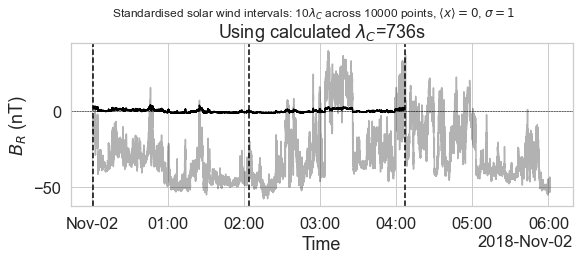

In [12]:
fig, ax = plt.subplots(figsize=(9, 3))
plt.plot(df, alpha=0.3, c="black")
plt.axvline(df.index[0], c="black", linestyle="dashed")
[
    plt.axvline(interval.index[-1], c="black", linestyle="dashed")
    for interval in ints
]
[plt.plot(interval, c="black") for interval in ints]
plt.axhline(0, c="black", linewidth=0.5, linestyle="--")
plt.suptitle(
    f"Standardised solar wind intervals: {tc_n}$\lambda_C$ across {interval_length} points, $\langle x \\rangle=0$, $\sigma=1$", y= 1.05
)
# # Add subtitle
plt.title(f"Using calculated $\lambda_C$={int(tc)}s")

# ax.set_xlim(interval_list_approx[0].index[0], interval_list_approx[2].index[-1])
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_ylabel("$B_R$ (nT)")
# Tidy the timestamp x-axis
# plt.xticks(rotation=20)

# plt.savefig("plots/int_standardised_demo.png")

In [13]:
raw_ints_meta = pd.DataFrame({
    "raw_int_start": df.index[0],
    "raw_int_end": df.index[-1],
    "tc": tc_list,
    "cadence": cadence_list,
})
raw_ints_meta

,raw_int_start,raw_int_end,tc,cadence
0,2018-11-02 00:01:09.100,2018-11-02 06:01:09.100,736.199,0.736199


In [14]:
ints_meta = pd.DataFrame({
    "int_start": [interval.index[0] for interval in ints],
    "int_end": [interval.index[-1] for interval in ints],
})
ints_meta.reset_index(inplace=True)
ints_meta.rename(columns={"index": "int_index"}, inplace=True)
ints_meta

,int_index,int_start,int_end
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712
1,1,2018-11-02 02:03:48.448,2018-11-02 04:06:27.712


### 3. Calculate the true SF and slope for each interval

In [15]:
lags = np.arange(1, 0.1 * len(ints[0]))
powers = [2]

In [16]:
sfs = pd.DataFrame()

for i, input in enumerate(ints):
    # print(f"\nCore {core} processing standardised interval {i}")
    good_output, slope = sf.compute_sf(pd.DataFrame(input), lags, powers, False, False, [10,100])
    
    good_output.insert(0, "int_index", i)
    sfs = pd.concat([sfs, good_output])
    ints_meta.loc[ints_meta["int_index"]==i, "slope"] = slope

sfs.head()

,int_index,lag,n,missing_percent,sf_2,sf_2_se
1.0,0,1.0,9999,0.0,0.015702,0.000594
2.0,0,2.0,9998,0.0,0.032877,0.001324
3.0,0,3.0,9997,0.0,0.047024,0.001895
4.0,0,4.0,9996,0.0,0.059901,0.002304
5.0,0,5.0,9995,0.0,0.071729,0.002690


[]

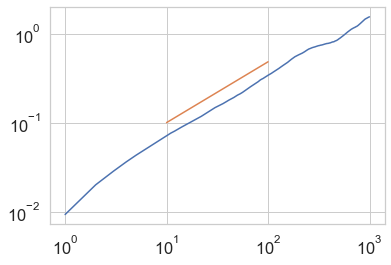

In [17]:
from src.data_import_funcs import pltpwrl
plt.plot(sfs.loc[sfs["int_index"]==1, "lag"], sfs.loc[sfs["int_index"]==1, "sf_2"])
pltpwrl(10,0.1, 10, 100, ints_meta.loc[ints_meta["int_index"]==1, "slope"].values)
plt.semilogx()
plt.semilogy()

### 4. Duplicate, gap and interpolate intervals, and calculate SFs and slopes

In [18]:
minimum_missing_chunks = 0.7
np.random.seed(123) # For reproducibility

In [19]:
index_list = []
version_list = []
handling_list = []
missing_list = []
slopes_list = []

sfs_copies = pd.DataFrame()
ints_copies = pd.DataFrame()

for index in range(len(ints)):
    input = ints[index]

    for j in range(times_to_gap):
        total_removal = np.random.uniform(0, 0.95)
        ratio_removal = np.random.uniform(minimum_missing_chunks, 1)
        # print("Nominal total removal: {0:.1f}%".format(total_removal * 100))
        # print("Nominal ratio: {0:.1f}%".format(ratio_removal * 100))
        prop_remove_chunks = total_removal * ratio_removal
        prop_remove_unif = total_removal * (1 - ratio_removal)
        bad_input_temp, bad_input_ind, prop_removed = ts.remove_data(
            input, prop_remove_chunks, chunks=np.random.randint(1, 10)
        )
        bad_input, bad_input_ind, prop_removed = ts.remove_data(
            bad_input_temp, prop_remove_unif
        )
        if prop_removed >= 0.95 or prop_removed == 0:
            # print(">95% or 0% data removed, skipping")
            continue

        bad_output, slope = sf.compute_sf(pd.DataFrame(bad_input), lags, powers, False, False, [10,100])
        bad_output["int_index"] = index
        bad_output["version"] = j
        bad_output["gap_handling"] = "none"
        sfs_copies = pd.concat([sfs_copies, bad_output])

        for handling in ["none", "lint"]:
            index_list.append(index)
            version_list.append(j)
            missing_list.append(prop_removed*100)
            handling_list.append(handling)

            if handling == "none":
                slopes_list.append(slope)
                # Once we are done with computing the SF, add some metadata to the interval
                bad_input_df = pd.DataFrame(bad_input)
                bad_input_df.reset_index(inplace=True)
                bad_input_df["int_index"] = index
                bad_input_df["version"] = j
                bad_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, bad_input_df])

            elif handling == "lint":
                interp_input = bad_input.interpolate(method="linear")
                interp_output, slope = sf.compute_sf(pd.DataFrame(interp_input), lags, powers, False, False, [10,100])
                slopes_list.append(slope)
                
                # # Once we are done with computing the SF, add some metadata to the interval
                interp_input_df = pd.DataFrame(interp_input)
                interp_input_df.reset_index(inplace=True)
                interp_input_df["int_index"] = index
                interp_input_df["version"] = j
                interp_input_df["gap_handling"] = handling
                ints_copies = pd.concat([ints_copies, interp_input_df])

                interp_output["int_index"] = index
                interp_output["version"] = j
                interp_output["gap_handling"] = handling
                
                # Correcting sample size and uncertainty for linear interpolation, same values as no handling
                interp_output["missing_percent"] = bad_output["missing_percent"]
                interp_output["sf_2_se"] = bad_output["sf_2_se"]

                sfs_copies = pd.concat([sfs_copies, interp_output])

In [20]:
ints_copies_meta = pd.DataFrame({"int_index": index_list, "version": version_list, "missing_percent_overall": missing_list, "gap_handling": handling_list, "slope": slopes_list})

### 5. Calculate errors relative to true values

Join original and copies dataframes and do column operation

In [21]:
ints_copies_meta = pd.merge(ints_meta, ints_copies_meta, how="inner", on="int_index", suffixes=("_orig", ""))
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])

In [22]:
sfs_copies = pd.merge(sfs, sfs_copies, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))
sfs_copies["sf_2_pe"] = (sfs_copies["sf_2"] - sfs_copies["sf_2_orig"]) / sfs_copies["sf_2_orig"] * 100

Calculate MAPE for each interval copy

In [23]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["none", "lint"]:
            mape = np.mean(np.abs(sfs_copies.loc[(sfs_copies["int_index"]==i) & (sfs_copies["version"]==j) & (sfs_copies["gap_handling"]==gap_handling), "sf_2_pe"]))
            ints_copies_meta.loc[(ints_copies_meta["int_index"]==i) & (ints_copies_meta["version"]==j) & (ints_copies_meta["gap_handling"]==gap_handling), "mape"] = mape

### 6. For PSP training set, create 2D and 3D heatmaps and export

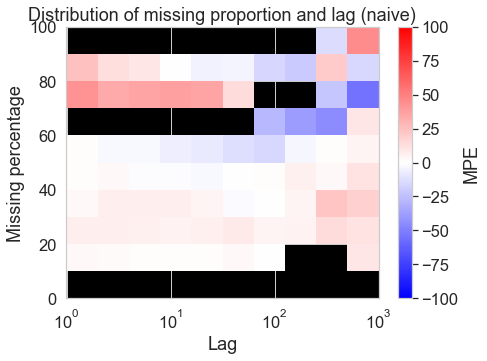

In [50]:
importlib.reload(sf)

missing_measure = "missing_percent"
n_bins = 10

heatmap_bin_vals_2d_naive, heatmap_bin_edges_2d_naive, lookup_table_2d_naive = (
    sf.create_heatmap_lookup(
        sfs_copies[sfs_copies["gap_handling"]=="none"], missing_measure, n_bins, log=True
    )
)

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d_naive[0],
    heatmap_bin_edges_2d_naive[1],
    heatmap_bin_vals_2d_naive.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing percentage")
plt.title("Distribution of missing proportion and lag (naive)")
ax.set_facecolor("black")
ax.set_xscale("log")

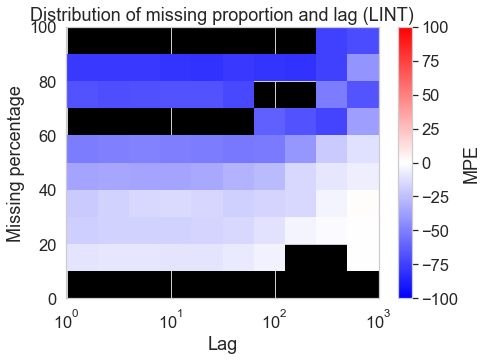

In [24]:
importlib.reload(sf)

missing_measure = "missing_percent"
n_bins = 10

heatmap_bin_vals_2d, heatmap_bin_edges_2d, lookup_table_2d = (
    sf.create_heatmap_lookup(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, log=True
    )
)

fig, ax = plt.subplots(figsize=(7, 5))
plt.pcolormesh(
    heatmap_bin_edges_2d[0],
    heatmap_bin_edges_2d[1],
    heatmap_bin_vals_2d.T,
    cmap="bwr",
)
plt.colorbar(label="MPE")
plt.clim(-100, 100)
plt.xlabel("Lag")
plt.ylabel("Missing percentage")
plt.title("Distribution of missing proportion and lag (LINT)")
ax.set_facecolor("black")
ax.set_xscale("log")

In [25]:
lookup_table_2d.head()

,lag,missing_percent,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,15.0,-10.235315,0.518008,-10.753323,-9.717307,1.114024,1.107632,1.120490
1,1.487531,25.0,-18.752573,0.000000,-18.752573,-18.752573,1.230808,1.230808,1.230808
2,1.487531,35.0,-20.739277,0.000000,-20.739277,-20.739277,1.261659,1.261659,1.261659
3,1.487531,45.0,-35.907395,0.000000,-35.907395,-35.907395,1.560242,1.560242,1.560242
4,1.487531,55.0,-50.868218,12.055340,-65.251112,-35.749219,2.035342,1.556401,2.877790


In [26]:
heatmap_bin_vals_3d, heatmap_bin_edges_3d, lookup_table_3d = (
    sf.create_heatmap_lookup_3D(
        sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, n_bins, True
    )
)

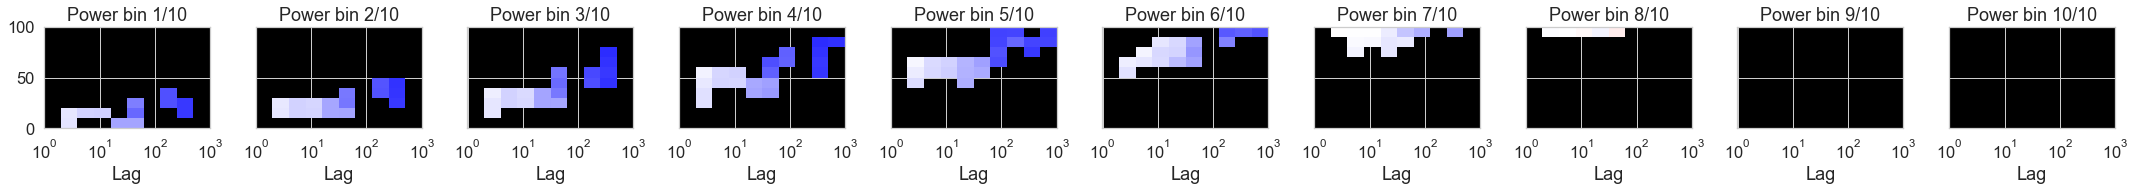

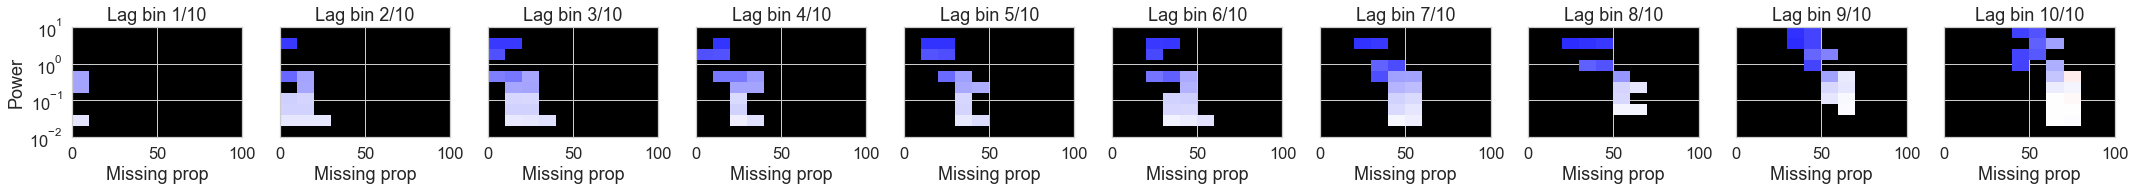

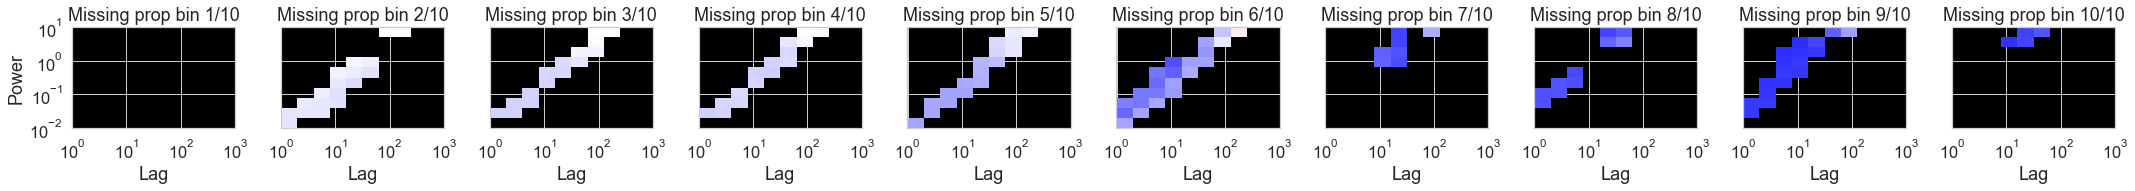

In [27]:
# Plotting 3D heatmaps

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[1],
        heatmap_bin_vals_3d[:, :, i],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.xlabel("Lag")
    plt.ylabel("Missing proportion")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].set_title(
        f"Power bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Lag")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_power.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[1],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[i, :, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    ax[i].set_xlabel("Missing prop")
    ax[i].set_ylabel("Power")
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogy()
    ax[i].set_title(
        f"Lag bin {i+1}/{n_bins}".format(np.round(heatmap_bin_edges_3d[2][i], 2))
    )
    ax[i].set_xlabel("Missing prop")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_lag.png")
#plt.close()

fig, ax = plt.subplots(1, n_bins, figsize=(n_bins * 3, 3), tight_layout=True)
# Remove spacing between subplots
plt.subplots_adjust(wspace=0.2)
for i in range(n_bins):
    c = ax[i].pcolormesh(
        heatmap_bin_edges_3d[0],
        heatmap_bin_edges_3d[2],
        heatmap_bin_vals_3d[:, i, :],
        cmap="bwr",
    )
    # plt.colorbar(label="MPE")
    c.set_clim(-100, 100)
    plt.title("Distribution of missing proportion and lag")
    ax[i].set_facecolor("black")
    ax[i].semilogx()
    ax[i].semilogy()
    ax[i].set_title(
        f"Missing prop bin {i+1}/{n_bins}".format(
            np.round(heatmap_bin_edges_3d[2][i], 2)
        )
    )
    ax[i].set_xlabel("Lag")
    ax[i].set_ylabel("Power")
    # Remove y-axis labels for all but the first plot
    if i > 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
#plt.savefig(save_dir + f"error_heatmap_b_{n_bins}_3d_missing.png")
#plt.close()


In [28]:
lookup_table_3d.head()

,lag,missing_percent,sf_2,mpe,mpe_sd,pe_min,pe_max,scaling,scaling_lower,scaling_upper
0,1.487531,15.0,0.014976,-10.753323,0.00000,-10.753323,-10.753323,1.120490,1.120490,1.120490
1,1.487531,45.0,0.014976,-35.907395,0.00000,-35.907395,-35.907395,1.560242,1.560242,1.560242
2,1.487531,55.0,0.014976,-35.749219,0.00000,-35.749219,-35.749219,1.556401,1.556401,1.556401
3,2.977669,15.0,0.014976,-10.088150,0.00000,-10.088150,-10.088150,1.112200,1.112200,1.112200
4,2.977669,15.0,0.029882,-9.927032,0.02559,-9.952622,-9.901442,1.110211,1.109896,1.110527


In [29]:
# Export the lookup table as a CSV
print("Exporting lookup table to CSV")
#lookup_table_3d.to_csv(save_dir + f"lookup_table_3d_b_{n_bins}.csv")

Exporting lookup table to CSV


### 7. For PSP and Wind test sets, apply the correction factor

In [30]:
# Importing lookup table

In [31]:
importlib.reload(sf)

# Apply 2D and 3D scaling to test set, report avg errors
print(f"Correcting interpolated test set intervals using 2D error heatmap with {n_bins} bins")
sfs_copies_corrected = sf.compute_scaling(
    sfs_copies[sfs_copies["gap_handling"]=="lint"], missing_measure, lookup_table_2d
)

Correcting interpolated test set intervals using 2D error heatmap with 10 bins


In [32]:
print(f"Correcting interpolated test set intervals using 3D error heatmap with {n_bins} bins")
sfs_copies_corrected = sf.compute_scaling_3d(
    sfs_copies_corrected[sfs_copies_corrected["gap_handling"]=="lint"], missing_measure, lookup_table_3d
)

Correcting interpolated test set intervals using 3D error heatmap with 10 bins


In [33]:
correction_wide =  sfs_copies_corrected[["int_index", "version", "lag", "missing_percent", "sf_2_corrected_2d", "sf_2_corrected_3d"]]
correction_long = pd.wide_to_long(correction_wide, ["sf_2"], i=["int_index", "version", "lag", "missing_percent"], j="gap_handling", sep="_", suffix=r"\w+")
correction_bounds_wide =  sfs_copies_corrected[["int_index", "version", "lag", "missing_percent", "sf_2_lower_corrected_2d", "sf_2_lower_corrected_3d", "sf_2_upper_corrected_2d", "sf_2_upper_corrected_3d"]]
correction_bounds_long = pd.wide_to_long(correction_bounds_wide, ["sf_2_lower", "sf_2_upper"], i=["int_index", "version", "lag", "missing_percent"], j="gap_handling", sep="_", suffix=r"\w+")

corrections_long = pd.merge(correction_long, correction_bounds_long, how="inner", on=["int_index", "version", "lag", "missing_percent", "gap_handling"]).reset_index()

In [34]:
# Removing the error columns: note that these might not actually be present at this stage in the test set

sfs_copies_small = sfs_copies[["int_index", "version", "missing_percent", "gap_handling", "lag", "sf_2"]]
sfs_copies_small = pd.concat([sfs_copies_small, corrections_long])
sfs_copies_small = pd.merge(sfs, sfs_copies_small, how="inner", on=["int_index", "lag"], suffixes=("_orig", ""))

In [35]:
sfs_copies_small

,int_index,lag,n,missing_percent_orig,sf_2_orig,sf_2_se,version,missing_percent,gap_handling,sf_2,sf_2_lower,sf_2_upper
0,0,1.0,9999,0.0,0.015702,0.000594,0,53.275328,none,0.018915,NaN,NaN
1,0,1.0,9999,0.0,0.015702,0.000594,0,53.275328,lint,0.010089,NaN,NaN
2,0,1.0,9999,0.0,0.015702,0.000594,1,57.235724,none,0.012306,NaN,NaN
3,0,1.0,9999,0.0,0.015702,0.000594,1,57.235724,lint,0.005456,NaN,NaN
4,0,1.0,9999,0.0,0.015702,0.000594,2,17.611761,none,0.016468,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
39955,1,999.0,9001,0.0,1.539483,0.021722,2,18.653483,corrected_3d,1.542590,1.510361,1.576225
39956,1,999.0,9001,0.0,1.539483,0.021722,3,88.212421,corrected_2d,1.761093,1.539483,3.676335
39957,1,999.0,9001,0.0,1.539483,0.021722,3,88.212421,corrected_3d,1.634782,1.284025,2.249194
39958,1,999.0,9001,0.0,1.539483,0.021722,4,100.000000,corrected_2d,2.459823,1.720040,3.963087


1. Training set needs errors before making corrections
2. Test set needs errors after applying corrections
3. Therefore, we may not need to perform this truncation followed by adding errors back in.

#### 7b. Calculate new slopes and MAPEs

In [36]:
sfs_copies_small["sf_2_pe"] = (sfs_copies_small["sf_2"] - sfs_copies_small["sf_2_orig"]) / sfs_copies_small["sf_2_orig"] * 100

In [37]:
# Adding rows as placeholders for when we correct with 2D and 3D heatmaps and want to calculate errors

dup_df = ints_copies_meta.drop(["slope", "slope_pe", "slope_ape", "mape"], axis=1)
dup_df.replace(["none","lint"], ["corrected_2d", "corrected_3d"], inplace=True)
ints_copies_meta = pd.concat([ints_copies_meta, dup_df])

In [38]:
for i in range(len(ints)):
    for j in range(times_to_gap):
        for gap_handling in ["none", "lint", "corrected_2d", "corrected_3d"]:
        # Calculate MAPE for 2D and 3D corrected SFs

            mape = np.mean(
                np.abs(
                    sfs_copies_small.loc[(sfs_copies_small["int_index"]==i) & 
                                    (sfs_copies_small["version"]==j) & 
                                    (sfs_copies_small["gap_handling"]==gap_handling), 
                                    "sf_2_pe"]))
            
            ints_copies_meta.loc[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]==gap_handling), 
                "mape"] = mape
            
            # Calculate power-law slope for 2D and 3D corrected SFs
            current_int = sfs_copies_small.loc[(sfs_copies_small["int_index"]==i) & 
                                (sfs_copies_small["version"]==j) & 
                                (sfs_copies_small["gap_handling"]==gap_handling)]

            pwrl_range = [10,100]
            # Fit a line to the log-log plot of the structure function over the given range
            min, max = pwrl_range[0], pwrl_range[1]

            slope = np.polyfit(
                np.log(current_int.loc[(current_int["lag"] >= 10) & (current_int["lag"] <= 100), "lag"]),
                np.log(current_int.loc[(current_int["lag"] >= 10) & (current_int["lag"] <= 100), "sf_2"]),
                1,
            )[0]


            ints_copies_meta.loc[
                (ints_copies_meta["int_index"]==i) & 
                (ints_copies_meta["version"]==j) & 
                (ints_copies_meta["gap_handling"]==gap_handling), 
                "slope"] = slope

### 8. Again, calculate errors relative to true values

In [39]:
ints_copies_meta["slope_pe"] = (ints_copies_meta["slope"] - ints_copies_meta["slope_orig"]) / ints_copies_meta["slope_orig"] * 100
ints_copies_meta["slope_ape"] = np.abs(ints_copies_meta["slope_pe"])

### 8a. Overall dataset summary stats

In [40]:
ints_copies_meta.groupby("gap_handling")[["missing_percent_overall", "slope", "slope_pe", "mape"]].agg(["mean", "median", "std", "min", "max"])

missing_percent_overall                                   slope  \
                                mean median       std   min    max      mean   
gap_handling                                                                   
corrected_2d                  42.546  41.56  24.74349  10.6  82.08  0.657856   
corrected_3d                  42.546  41.56  24.74349  10.6  82.08  0.665137   
lint                          42.546  41.56  24.74349  10.6  82.08  0.624672   
none                          42.546  41.56  24.74349  10.6  82.08  0.592785   

                                                       slope_pe            \
                median       std       min       max       mean    median   
gap_handling                                                                
corrected_2d  0.669496  0.039433  0.554784  0.695998  -0.977056 -1.092393   
corrected_3d  0.665309  0.054699  0.579585  0.771055   0.167364  0.110686   
lint          0.673055  0.111349  0.368548  0.707094  -5.787466  3.239268   
none          0.658340  0.134546  0.262135  0.712574 -10.540121 -0.840124   

                                                    mape             \
                    std        min        max       mean     median   
gap_handling                                                          
corrected_2d   5.728057 -14.147643   7.705153  11.070258  12.749914   
corrected_3d   8.686414 -15.109444  19.320287   8.258027   9.107505   
lint          17.530638 -46.019501   9.422359  33.450782  23.062975   
none          20.942548 -61.605599   4.369309  21.969893  16.166617   

                                              
                    std       min        max  
gap_handling                                  
corrected_2d   8.218560  1.373504  20.872140  
corrected_3d   5.813871  1.062615  16.385478  
lint          30.482825  1.527348  74.976747  
none          17.522318  6.629450  53.621609

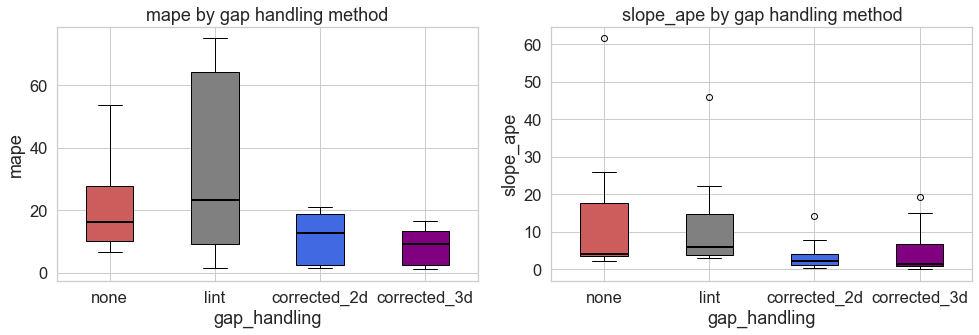

In [41]:
import matplotlib.pyplot as plt

# Assuming ints_copies_meta is your DataFrame
# Define the list of columns to plot
columns = ["mape", "slope_ape"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

custom_order = ["none", "lint", "corrected_2d", "corrected_3d"]
colors = ['indianred', 'grey', 'royalblue', 'purple']

# Create boxplots for each column
for col, ax in zip(columns, axes):
    data_to_plot = [ints_copies_meta[ints_copies_meta['gap_handling'] == method][col] for method in custom_order]
    box = ax.boxplot(data_to_plot, patch_artist=True)
    
    # Set colors for the boxes
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Set colors for the median lines
    median_color = 'black'
    for median in box['medians']:
        median.set_color(median_color)
        median.set_linewidth(2)  # optional: set line width to make it more prominent

    ax.set_title(f'{col} by gap handling method')
    ax.set_xlabel('gap_handling')
    ax.set_ylabel(f'{col}')
    ax.set_xticklabels(custom_order)

# Adjust layout
plt.tight_layout()
plt.suptitle('')  # Remove the default title to avoid overlap
plt.show()


# NEXT
1. Re-run DONE
2. Email Marcus
2. Finish current ad-hoc plots
3. Make target plots
4. Finalise relational database 
5. Run on 3 files
    - Figure out indexing of raw and processed int dfs
6. Run on a couple more dups maybe
7. Add smoothing
7. Figure out train-test split, noting different stages of having errors in the respective dataframes
8. Thinking about splitting and reducing of data, turn into scripts with parallel capability.
9. Quick scaling study on NeSI, investigating bad ints
10. Results for 1 year of PSP, 1 month of Wind
10. Up the ante to two years, while writing up existing results.

### 8b. Check final dataframes

Look at Jupyter variables to confirm what we've got 

## 9. Producing target plots

In [42]:
ints_copies_meta.head()

,int_index,int_start,int_end,slope_orig,version,missing_percent_overall,gap_handling,slope,slope_pe,slope_ape,mape
0,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,45.55,none,0.668366,3.429146,3.429146,9.976899
1,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,0,45.55,lint,0.680066,5.239747,5.239747,35.445569
2,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,55.68,none,0.517169,-19.968509,19.968509,53.621609
3,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,1,55.68,lint,0.538852,-16.613049,16.613049,72.353682
4,0,2018-11-02 00:01:08.448,2018-11-02 02:03:47.712,0.646207,2,14.97,none,0.670161,3.706994,3.706994,16.069578


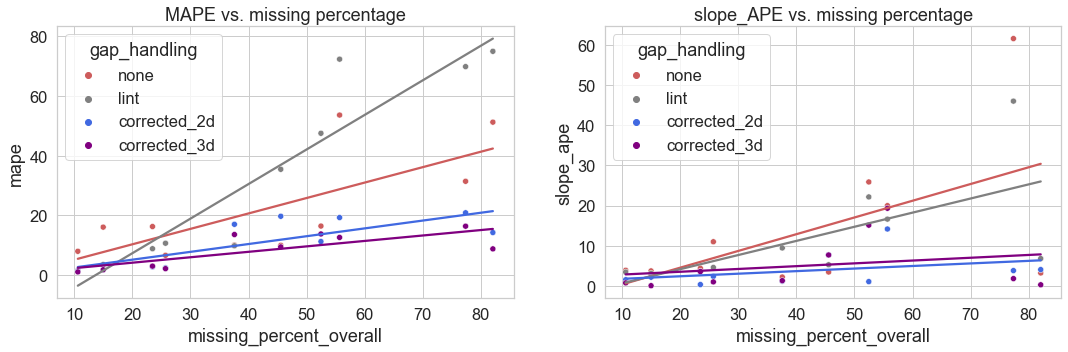

In [43]:
# Make scatterplot of mape vs. missing_percent, coloured by gap handling
palette = dict(zip(custom_order, colors))

# Plotting the MAPE vs. missing percentage
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.scatterplot(data=ints_copies_meta, x="missing_percent_overall", y="mape", hue="gap_handling", palette=palette, ax = ax[0])
# Add regression lines
ax[0].set_title("MAPE vs. missing percentage")

# Add regression lines for each group
unique_gap_handling = ints_copies_meta['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_copies_meta[ints_copies_meta['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="mape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[0])

sns.scatterplot(data=ints_copies_meta, x="missing_percent_overall", y="slope_ape", hue="gap_handling", palette=palette, ax = ax[1])
# Add regression lines
ax[1].set_title("slope_APE vs. missing percentage")

# Add regression lines for each group
unique_gap_handling = ints_copies_meta['gap_handling'].unique()

for gap_handling_method in unique_gap_handling:
    subset = ints_copies_meta[ints_copies_meta['gap_handling'] == gap_handling_method]
    sns.regplot(data=subset, x="missing_percent_overall", y="slope_ape", scatter=False, 
                color=palette[gap_handling_method], label=gap_handling_method, ci=None, ax = ax[1])

In [44]:
# Plotting the MAPE vs. missing percentage
plt.figure(figsize=(10, 6))


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


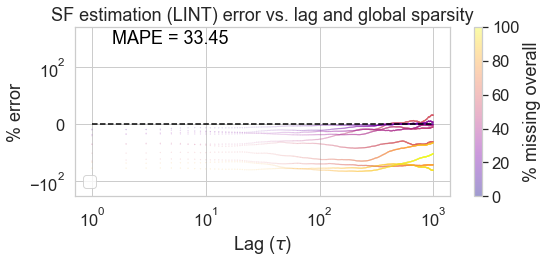

In [45]:
importlib.reload(sf)

sf.plot_error_trend_line(sfs_copies_small[sfs_copies_small["gap_handling"]=="lint"], estimator="sf_2", title = "SF estimation (LINT) error vs. lag and global sparsity", y_axis_log=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


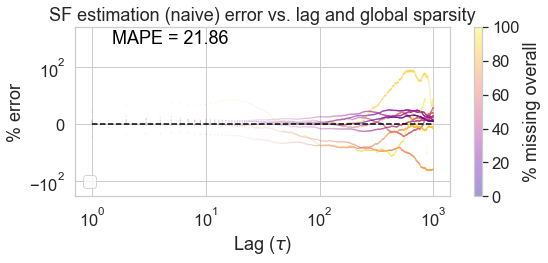

In [46]:
sf.plot_error_trend_line(sfs_copies_small[sfs_copies_small["gap_handling"]=="none"], estimator="sf_2", title = "SF estimation (naive) error vs. lag and global sparsity", y_axis_log=True)

In [47]:
# Annotate each heatmap trace with info
def annotate_curve(ax, x, y, text, offset_scaling=(0.3, 0.1)):
    # Find the index of y value closest to the median value
    idx = np.argmin(np.abs(y - np.percentile(y, 20)))

    # Coordinates of the point of maximum y value
    x_max = x[idx]
    y_max = y[idx]

    # Convert offset from axes fraction to data coordinates
    x_text = 10 ** (offset_scaling[0] * np.log10(x_max))  # Log-axis
    y_text = y_max + offset_scaling[1] * (ax.get_ylim()[1] - ax.get_ylim()[0])

    # Annotate with the text, adjusting the position with xytext_offset
    ax.annotate(
        text,
        xy=(x_max, y_max - 1),
        xytext=(x_text, y_text),
        # xycoords="axes fraction",
        # textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
        bbox=dict(facecolor="white", edgecolor="white", boxstyle="round", alpha=0.7),
    )

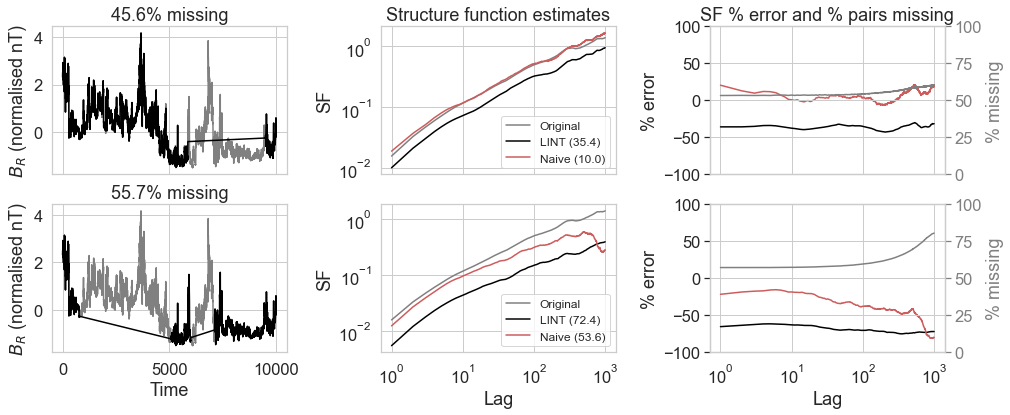

In [48]:
int_index=0
num_version_to_plot = 2

fig, ax = plt.subplots(num_version_to_plot, 3, figsize=(16, num_version_to_plot*3))

for version in range(num_version_to_plot):
    ax[version, 0].plot(ints[int_index].values, c = "grey")
    ax[version, 0].plot(
        ints_copies.loc[(ints_copies["int_index"]==int_index) & 
                        (ints_copies["version"]==version) & 
                        (ints_copies["gap_handling"]=="lint"), "B_R"].values, c="black")

    # Put missing_percent_overall in the title
    ax[version, 0].set_title(f"{ints_copies_meta.loc[(ints_copies_meta['int_index']==int_index) & (ints_copies_meta['version']==version) & (ints_copies_meta['gap_handling']=='lint'), 'missing_percent_overall'].values[0]:.1f}% missing")

    # Plot the SF
    ax[version, 1].plot(
        sfs.loc[(sfs["int_index"]==int_index), "lag"],
        sfs.loc[(sfs["int_index"]==int_index), "sf_2"], c="grey", label = "Original")

    ax[version, 1].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "sf_2"], c="black", 
                        label="LINT ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="lint"), "mape"].values[0]),)
    ax[version, 1].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="none"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="none"), "sf_2"], c="indianred",
                        label="Naive ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                        (ints_copies_meta["version"]==version) &
                                        (ints_copies_meta["gap_handling"]=="none"), "mape"].values[0]),)
    
    # Plot the sf_2_pe
    ax[version, 2].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="lint"), "sf_2_pe"], c="black")
    ax[version, 2].plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="none"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="none"), "sf_2_pe"], c="indianred")
    
    # plot sample size n on right axis
    ax2 = ax[version, 2].twinx()
    ax2.plot(
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="none"), "lag"], 
        sfs_copies.loc[(sfs_copies["int_index"]==int_index) & 
                        (sfs_copies["version"]==version) & 
                        (sfs_copies["gap_handling"]=="none"), "missing_percent"], c="grey")

    # Label the axes
    ax[1, 0].set_xlabel("Time")
    ax[version, 0].set_ylabel("$B_R$ (normalised nT)")
    ax[1, 1].set_xlabel("Lag")
    ax[version, 1].set_ylabel("SF")
    ax[1, 2].set_xlabel("Lag")
    ax[version, 2].set_ylabel("% error")
    ax2.set_ylabel("% missing", color="grey")
    ax2.tick_params(axis="y", colors="grey")
    ax2.set_ylim(0,100)

    #ax[version, 2].axhline(0, c="black", linestyle="--")
    ax[version, 2].set_ylim(-100, 100)

    ax[version, 1].set_xscale("log")
    ax[version, 1].set_yscale("log")
    ax[version, 2].set_xscale("log")
    ax[version, 1].legend(fontsize=12)
    [ax[0, i].set_xticklabels([]) for i in range(3)]

# Add titles
ax[0, 1].set_title("Structure function estimates")
ax[0, 2].set_title("SF % error and % pairs missing")
plt.subplots_adjust(wspace=0.4)


   missing_percent_overall  gap_handling       mape  slope_pe
0                    45.55          none   9.976899  3.429146
1                    45.55          lint  35.445569  5.239747
0                    45.55  corrected_2d  19.709140  7.705153
1                    45.55  corrected_3d   9.437230 -7.675801
   missing_percent_overall  gap_handling       mape   slope_pe
2                    55.68          none  53.621609 -19.968509
3                    55.68          lint  72.353682 -16.613049
2                    55.68  corrected_2d  19.274762 -14.147643
3                    55.68  corrected_3d  12.618582  19.320287


(0.0, 100.0)

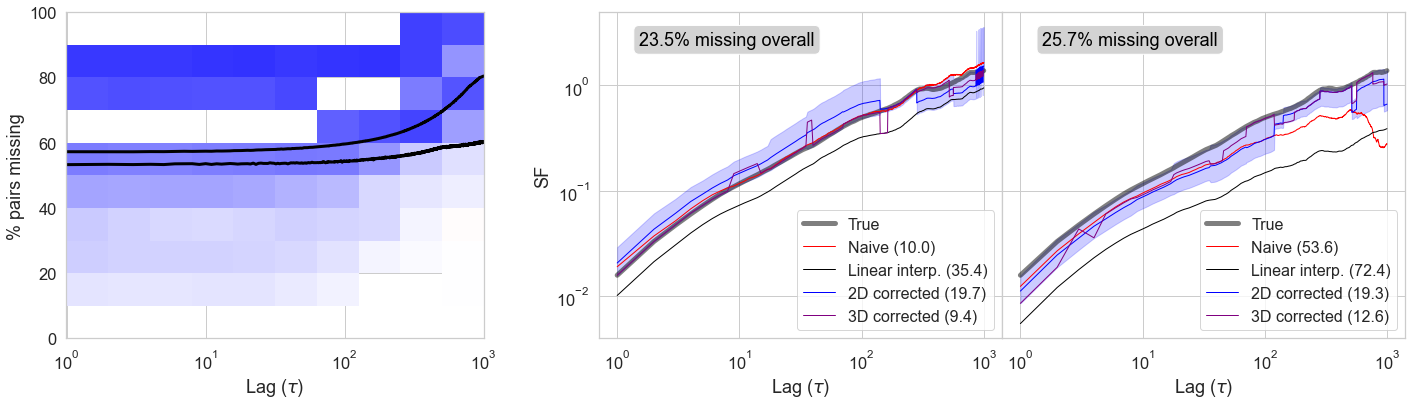

In [49]:
fig = plt.figure(figsize=(20, 6))

# Create a GridSpec layout with specified width ratios and horizontal space
gs1 = GridSpec(1, 1, left=0.06, right=0.35)
gs2 = GridSpec(1, 2, left=0.43, right=0.99, wspace=0)

# Create subplots
ax0 = fig.add_subplot(gs1[0, 0])
ax1 = fig.add_subplot(gs2[0, 0])

for version in range(2):

    if version == 0:
        ax = ax1
        ax.set_ylabel("SF")
    else:
        ax = fig.add_subplot(gs2[0, version], sharey=ax1)
        plt.setp(ax.get_yticklabels(), visible=False)
        
    ax.plot(
        sfs[sfs["int_index"]==int_index]["lag"],
        sfs[sfs["int_index"]==int_index]["sf_2"],
        color="black",
        label="True",
        lw=5,
        alpha=0.5,
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="none"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="none"), "sf_2"],
        color="red",
        lw=1,
        label="Naive ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="none"), "mape"].values[0]),
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="lint"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="lint"), "sf_2"],
        color="black",
        lw=1,
        label="Linear interp. ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="lint"), "mape"].values[0]),
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "sf_2"],
        color="blue",
        lw=1,
        label="2D corrected ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="corrected_2d"), "mape"].values[0]),
    )
    ax.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "sf_2"],
        color="purple",
        lw=1,
        label="3D corrected ({:.1f})".format(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) &
                                                                (ints_copies_meta["version"]==version) &
                                                                (ints_copies_meta["gap_handling"]=="corrected_3d"), "mape"].values[0]),
    )
    ax.fill_between(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "sf_2_lower"],
            sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_2d"), "sf_2_upper"],
        color="blue",
        alpha=0.2,
    )

    missing = matching_values = ints_copies_meta.loc[
        (ints_copies_meta["int_index"] == index) & (ints_copies_meta["version"] == version),
        "missing_percent_overall"
    ].values


    ax.annotate(
        f"{float(missing[0]):.1f}% missing overall",
        xy=(1, 1),
        xycoords="axes fraction",
        xytext=(0.1, 0.9),
        textcoords="axes fraction",
        transform=ax.transAxes,
        c="black",
        fontsize=18,
        bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round"),
    )

    ax.legend(loc="lower right", fontsize = 16)
    ax.semilogx()
    ax.semilogy()


    # PLOTTING HEATMAP IN FIRST PANEL

    c = ax0.pcolormesh(
        heatmap_bin_edges_2d[0],
        heatmap_bin_edges_2d[1],  # convert to % Missing
        heatmap_bin_vals_2d.T,
        cmap="bwr",
    )
    # fig.colorbar(c, ax=ax0, label="MPE")
    c.set_clim(-100, 100)
    c.set_facecolor("black")
    # ax0.set_xlabel("Lag")
    ax0.plot(
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
        sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
                                                                        (sfs_copies_small["gap_handling"]=="corrected_3d"), "missing_percent"],
        c="black",
        lw=3,
    )
    # alphabet = "abcdefghijklmnopqrstuvwxyz"
    # annotate_curve(
    #     ax0,
    #     sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
    #                                                                     (sfs_copies_small["gap_handling"]=="corrected_3d"), "lag"],
    #     sfs_copies_small.loc[(sfs_copies_small["int_index"]==int_index) & (sfs_copies_small["version"]==version) & 
    #                                                                     (sfs_copies_small["gap_handling"]=="corrected_3d"), "missing_percent"],
    #     f"{alphabet[version]}",
    #     offset_scaling=(0.8, -0.3),
    # )
    # ax.annotate(
    #     f"{alphabet[i]}: {interp_outputs_test_df.loc[input_ind, int_version]['missing_prop_overall'].mean()*100:.1f}% missing overall",
    #     xy=(1, 1),
    #     xycoords="axes fraction",
    #     xytext=(0.1, 0.9),
    #     textcoords="axes fraction",
    #     transform=ax.transAxes,
    #     c="black",
    #     fontsize=12,
    #     bbox=dict(facecolor="lightgrey", edgecolor="white", boxstyle="round"),
    # )
    ax.set_xlabel("Lag ($\\tau$)")

    print(ints_copies_meta.loc[(ints_copies_meta["int_index"]==int_index) & (ints_copies_meta["version"]==version)][["missing_percent_overall", "gap_handling", "mape", "slope_pe"]])

    
ax0.set_xscale("log")
ax0.set_xlabel("Lag ($\\tau$)")
ax0.set_ylabel("% pairs missing")
ax0.set_ylim(0, 100)

## 10. Running for multiple files and with training and test splits

Make it very clear how many files, intervals, repetitions I have